In [1]:
#use environment planet_env(Pythin 3.11.7)
#!pip install pysheds

In [1]:
import pysheds

In [2]:
import numpy as np
import pandas as pd
from pysheds.grid import Grid
import geopandas as gpd
from shapely import geometry, ops
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')
sns.set_palette('husl')
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

In [3]:
demdir = '/home/etboud/projects/Data/output/'
id = 'mosaic_output'
dem_fn = os.path.join(demdir, id+'.tif')


# /home/etboud/projects/Data/output/mosaic_output.tif

In [4]:
dem_fn

'/home/etboud/projects/Data/output/mosaic_output.tif'

In [5]:
# Instatiate a grid from a raster
grid = Grid.from_raster(dem_fn, data_name='dem')

In [6]:
dem = grid.read_raster(dem_fn, data_name='dem')

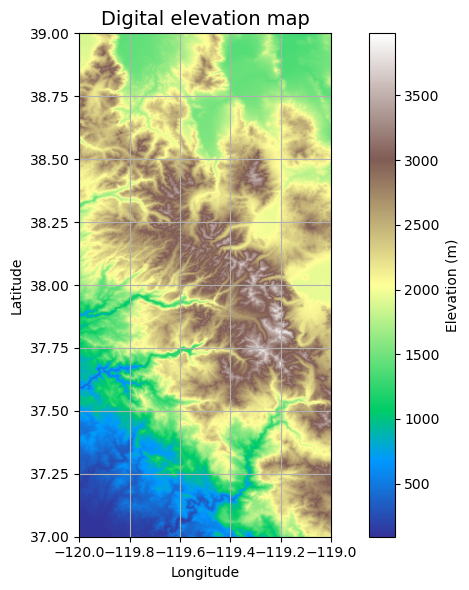

In [7]:

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

## Fill in pits on DEM
pixels with values lower than surrounding values may be problematic. Here we give those pixels the same values as their surrounding ones. Now there shouldn't be accumulation issues from the pits.

In [8]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

## Estimating Flow Direction
Here we estimate the direction map, defining 8 possible directions that one cell can follow. Each number is a different direction.

In [9]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

In [10]:
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

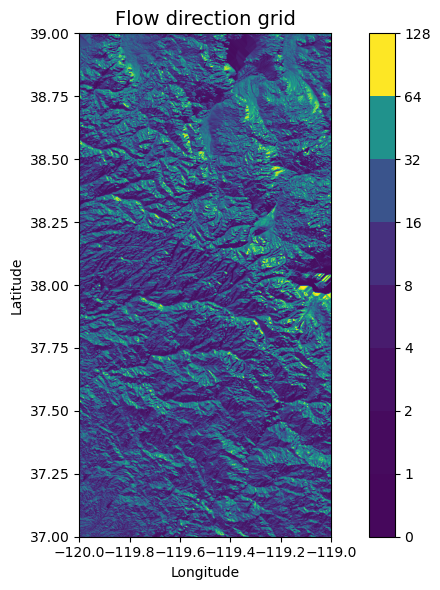

In [11]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries, values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

## Estimating Flow Accumulation
This part estimates total contributing area for each cell. Sums the number of cells that contribute to each cell.

In [12]:
#Calculate flow accumulation
#--------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

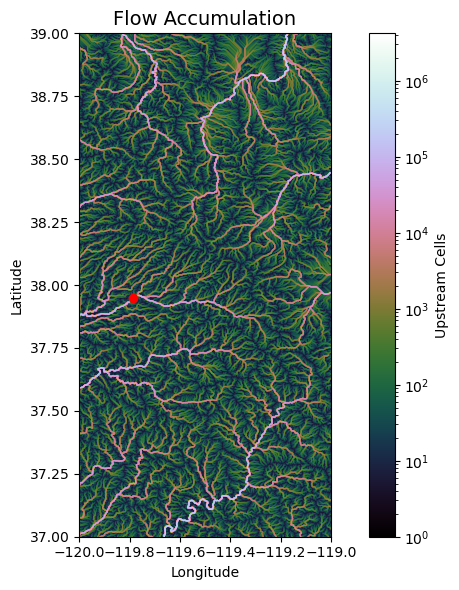

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')

point_x, point_y = -119.7879546, 37.9476989
plt.scatter(point_x, point_y, color='red', label='Your Point', zorder=2)
plt.xlim(grid.extent[:2])
plt.ylim(grid.extent[2:])
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

## Catchment Delineation
First select the pour point (most downstream of the catchment).You can use QGIS to determine these coordinates by using the Identify Features Icon and clock on the downstream pixel.

Points are snapped to the nearest cell in a binary mask. The 1000 specifies only cells with accumulated flow values greater than 1000 will be considered for snapping

In [16]:
# Delineate a catchment
# ---------------------
# Specify pour point
x, y = -119.7879546, 37.9476989

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

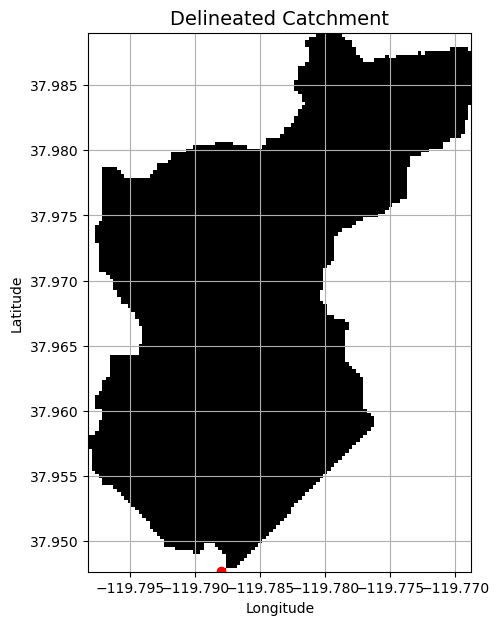

In [36]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(9,7))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
point_x, point_y = -119.7879546, 37.9476989
plt.scatter(point_x, point_y, color='red', label='Your Point', zorder=2)
plt.xlim(grid.extent[:2])
plt.ylim(grid.extent[2:])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

## Extract River Network

If number of flow accumulation is greater than threshold the pixels will be characterized as a river. The lower the number, the denser the river network.

In [18]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

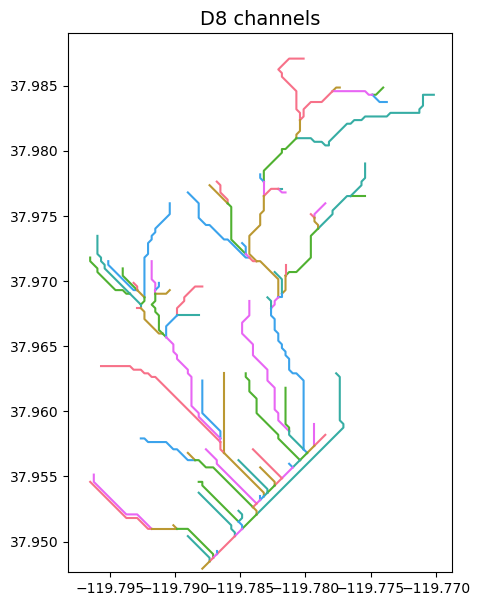

In [34]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(9,7))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

In [22]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                               xytype='coordinate')

In [32]:
# from matplotlib.patches import FancyArrowPatch
# from matplotlib.offsetbox import AnnotationBbox
# from matplotlib.patches import FancyArrowPatch, ArrowStyle
import contextily as ctx

In [24]:
dist.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

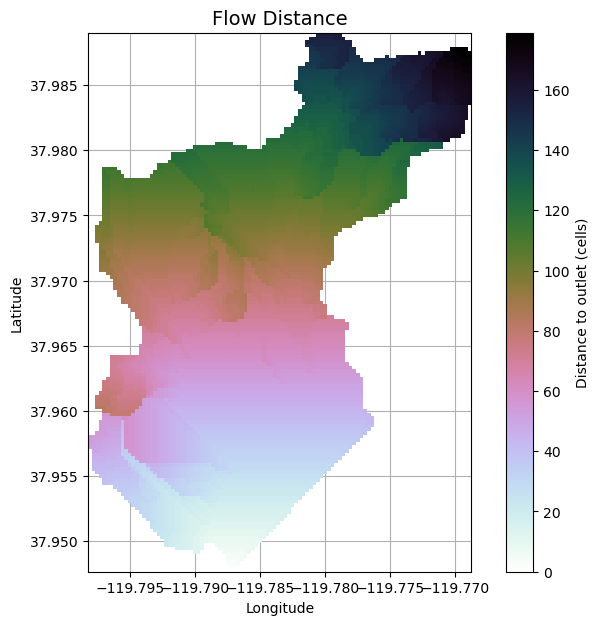

In [38]:
fig, ax = plt.subplots(figsize=(9,7))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
#ctx.add_basemap(ax=ax,crs=dist.crs,source=ctx.providers.Esri.WorldImagery,attribution='')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
# style = ArrowStyle('Fancy', head_length=1, head_width=1.5, tail_width=0.5)
# arrow = FancyArrowPatch((0, 0), (1, 1), mutation_scale=25, arrowstyle=style, color='k') 
# north_arrow = FancyArrowPatch((0.95, 0.95), (0.95, 0.85),mutation_scale=25, arrowstyle=style, color='k')
# ax.add_patch(north_arrow)
# ax.annotate('N', xy=(0.95, 0.95), xytext=(0.95, 0.96), ha='center', va='center')


In [ ]:
# saving rivers as shapefile
line_strings = []

for branch in branches['features']:
    line_coords = branch['geometry']['coordinates']
    line = LineString(line_coords)
    line_strings.append(line)

gdf = gpd.GeoDataFrame(geometry=line_strings)
gdf.plot()

gdf.to_file('rivers.shp')

citation

@misc{bartos_2020,
    title  = {pysheds: simple and fast watershed delineation in python},
    author = {Bartos, Matt},
    url    = {https://github.com/mdbartos/pysheds},
    year   = {2020},
    doi    = {10.5281/zenodo.3822494}
}